In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

# A/B testing to improve Conversion Rates

You work for Company K. Company K is a video streaming service that is selling subscriptions. After running a few analyses, you suggest to the Product Team that placing more prominent upsells on the landing page may result in higher conversion rates (visitors signing up for the subscription). The Product Team took your suggestion with excitement and the engineering team went ahead and implemented the experiment right away. 

The experiment ran for the month of February 2020. You prepared a few datasets beforehand that will help you in analyzing the success of the A/B test.
The A/B test had two experiment groups, A & B, in which visitors assigned to A were in the control group and visitors assigned to B received the new variant with the new upsells. You suggest to assign approximately 7% of the daily visitors to the experiment, applying a 50/50 split among the two variants.

You have the following datasets:

1. `first_pageviews`: This is a summary of all the unsubscribed users and the timestamp of their first pageview. Users get assigned according to their cookies, which is how we make sure that a user may not be assigned to two different groups when they reach our landing page. Since visitors haven't signed up at this point, they don't have a `user_id`, instead, we assign them a random but unique `anonymous_id`. If visitors get assigned to an experiment, you should see a non-null value in the `exp_id` column. Your experiment has the ids **101** for control and **102** for the variant.
2. `subscribers`: This table shows you which users have subscribed at what point in time. To subscribe, you need to be a registered user, which is how you can uniquely identify each subscriber. Since we only sell yearly subscriptions, users cannot have more than 1 subscription within 365 days. 
3. `users`: This table is useful to link the first pageview of unsubscribed visitors to our subscribers. It keeps track of the `anonymous_id` we assigned to them and maps to the `user_id` we assigned after they sign up

Immediately after the end of the experiment, the Product Manager approaches you overly excited and wants you to analyze the success of the experiment.

You can find the datasets in the `data/2020-03-01` folder.

In [2]:
# load the datasets
def load_csv(filename):
    return pd.read_csv(os.path.join("data", "2020-03-01", f"{filename}.csv"))
csvs = ["first_pageviews", "users_mar01", "subscriptions_mar01"]
first_pageviews = load_csv(csvs[0])
users = load_csv(csvs[1])
subscriptions = load_csv(csvs[2])

## Inspect the data

In [3]:
# show the first 5 lines of each dataset
dfs = [first_pageviews, users, subscriptions]
for df in dfs:
    print(df.head(), end="\n---\n")

      date_id                          anonymous_id  exp_id
0  2020-01-16  4d005f94-e06f-493c-b569-9efb5ce4d203     NaN
1  2020-01-16  948ad58a-f483-4007-aa56-280aa018427b     NaN
2  2020-01-16  31f4f2e4-4ae6-417b-8a6d-53b98a719145     NaN
3  2020-01-16  24747dc7-355a-44b0-95c6-0caa91cd4ae4     NaN
4  2020-01-16  0162c4f8-7bc2-4432-90b9-bfb61f5e57b3     NaN
---
                           anonymous_id                               user_id
0  e575dd8c-f02c-4a1a-8a53-fef7ff2b9f95  b67781da-3a0f-48af-80d8-728d3ec31c66
1  a92532b2-0317-49bb-9f00-3d9b9ae71ea5  ce1764ca-91a2-4c2e-95fe-c415c5df7be5
2  9c39b4d4-d7da-49e2-bcd9-4abee3e211f6  b24712a4-40b7-4841-a9e9-f566d9ed48a9
3  858cc4cc-dcd2-4897-815b-500a2ee8c00e  d0e4f27e-11ab-470c-85db-4f7389ba63d4
4  96a9ad69-568e-40bd-9ff7-3e6b8e0d3f9a  91b679ad-38cc-4569-b5fc-8a98dc858b8d
---
                                user_id                     created_at  \
0  b67781da-3a0f-48af-80d8-728d3ec31c66  2020-01-26 09:00:55.628471160   
1  ce1764ca-91a2

In [4]:
# check the data types and set them properly for each dataset
first_pageviews["date_id"] = pd.to_datetime(first_pageviews["date_id"])
subscriptions["created_at"] = pd.to_datetime(subscriptions["created_at"])
for df in dfs:
    print(df.dtypes, end="\n---\n")

date_id         datetime64[ns]
anonymous_id            object
exp_id                 float64
dtype: object
---
anonymous_id    object
user_id         object
dtype: object
---
user_id               object
created_at    datetime64[ns]
client_app            object
dtype: object
---


In [5]:
fp_grouped = (first_pageviews
              .groupby("date_id")["date_id"]
              .count())
fp_grouped

date_id
2020-01-16    43732
2020-01-17    46950
2020-01-18    32288
2020-01-19    34464
2020-01-20    52184
2020-01-21    47600
2020-01-22    47255
2020-01-23    48753
2020-01-24    42981
2020-01-25    38896
2020-01-26    35450
2020-01-27    51554
2020-01-28    52380
2020-01-29    42687
2020-01-30    48363
2020-01-31    48357
2020-02-01    41166
2020-02-02    40339
2020-02-03    49347
2020-02-04    46408
2020-02-05    40654
2020-02-06    47631
2020-02-07    45555
2020-02-08    38665
2020-02-09    33122
2020-02-10    52331
2020-02-11    51635
2020-02-12    40572
2020-02-13    46190
2020-02-14    42802
2020-02-15    37441
2020-02-16    38375
2020-02-17    50122
2020-02-18    43863
2020-02-19    47800
2020-02-20    48136
2020-02-21    40440
2020-02-22    33624
2020-02-23    35621
2020-02-24    54455
2020-02-25    48973
2020-02-26    48298
2020-02-27    45686
2020-02-28    41641
2020-02-29    32782
Name: date_id, dtype: int64

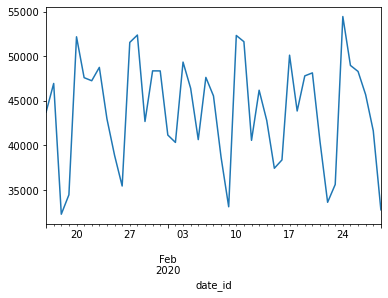

In [27]:
# plot first pageview per day to inspect if you can spot any outliers or anything suspicious
fp_grouped.plot(kind="box")

In [7]:
# check the assignment into the experiment. You should see that 7% of the visitors were 
# assigned to the experiment with a 50/50 split among the two variants

print(len(first_pageviews) * .07)

first_pageviews["exp_id"].value_counts()

138429.76


101.0    67887
102.0    67715
Name: exp_id, dtype: int64

The assignment seemed to work as planned. You can now continue with the data prep.

## Create experiment dataset

To simplify the analysis, filter and merge the datasets to only focus on what's relevant. That is, you only care about visitors that were actually assigned to the experiment. Among those, you want to know how many subscribed. The proportion of those, for each group, is the conversion rate.

In [8]:
# merge the tables so you can see all visitors assigned to the experiment 
# and whether they subscribed or not
# create a dummy column for whether a user subscribed or not

first_pageviews = first_pageviews.dropna()

combi = (first_pageviews
         .merge(users, how="left", on="anonymous_id"))
combi["subscribed"] = np.where(combi["user_id"].isna(), 
                               0, 1)
combi

,date_id,anonymous_id,exp_id,user_id,subscribed
0,2020-02-01,c8bc65ae-e5bb-47b0-b2ba-a3e32f086c39,101.0,NaN,0
1,2020-02-01,5808da06-67c6-467f-bedd-aa872839ccde,101.0,NaN,0
2,2020-02-01,3265ddda-fefc-471f-b956-fa88b1d85e08,101.0,NaN,0
3,2020-02-01,0b633f23-c070-4289-b323-058c0a4105fb,101.0,NaN,0
4,2020-02-01,72c9c459-ae27-407a-a257-901678774df2,101.0,NaN,0
...,...,...,...,...,...
135597,2020-02-29,1a58f77c-39ce-4aa7-ba43-92857081c8ea,102.0,NaN,0
135598,2020-02-29,69dee06a-03b5-46b5-b5b7-480790769ef2,102.0,NaN,0
135599,2020-02-29,df28818f-57af-4dbb-a3df-8f0f68dee469,102.0,NaN,0
135600,2020-02-29,38b75810-513e-4b7b-a1cf-71cd37ae203d,102.0,NaN,0


## Inspect experiment data

Before running the test, you want to spend some time checking the data you collected.

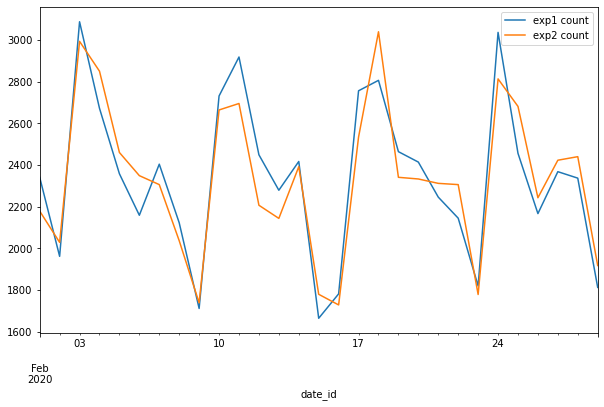

In [9]:
# plot a timeseries of daily visitors that were assigned to an experiment
# plot a line for each exp_id
exp1 = (combi[combi["exp_id"] == 101.0]
        .groupby("date_id")[["date_id"]]
        .count()
        .rename(columns={"date_id": "exp1 count"}))
exp2 = (combi[combi["exp_id"] == 102.0]
        .groupby("date_id")[["date_id"]]
        .count()
        .rename(columns={"date_id": "exp2 count"}))

fig, ax = plt.subplots(figsize=(10, 6))
exp1.plot(kind="line", ax=ax)
exp2.plot(kind="line", ax=ax)

In [10]:
# does the time range match the experiment requirements?
# yes
# Do the lines indicate an equal assignment over time?
# yes

## Describing the data

Compute the differences among the groups, before running a statistical test

In [11]:
# compute the number of conversion for each experiment group
rates = (combi
         .groupby("exp_id")["subscribed"]
         .sum()
         .astype("int64"))

In [12]:
# compute the conversion rate for each experiment group
cr_1 = rates.iloc[0] / int(exp1.sum())
cr_2 = rates.iloc[1] / int(exp2.sum())

for cr in [cr_1, cr_2]:
    print(f"Convertion rate: {cr}")

Convertion rate: 0.007262067848041598
Convertion rate: 0.007900760540500628


In [13]:
# interpret the results. From just looking at the numbers, which group performed better 
# with respect to conversions or conversion rates?
# Group 102 performed better

You should see that there is a difference in the conversion rate across the different experiment groups.

Are there any differences among the subscibers for each group with respect to the client application they signed up through?

In [14]:
# Compute relative frequency for each client_app through which they subscribed in each experiment group
app = (combi
       .merge(subscriptions, how="left", on="user_id"))
app[app["client_app"].notna()]

,date_id,anonymous_id,exp_id,user_id,subscribed,created_at,client_app
308,2020-02-01,5064fc3e-279d-4e32-a453-fb0ec8b1f66b,101.0,28df4835-4ace-45d3-a657-5b988d89c779,1,2020-02-29 23:58:41.641215300,ios
421,2020-02-01,36b5d755-edb9-4f67-b1cc-8b13a55c6f8b,101.0,2602e1dc-974b-4e16-9395-0e769a0e5268,1,2020-02-10 16:38:35.572462200,web
692,2020-02-01,44856256-d2b0-4053-9b15-e5a63bd3e55f,101.0,5b70b04d-0baa-4f3f-99ff-8d87f3673c7e,1,2020-02-01 12:22:28.760879580,web
706,2020-02-01,b1c43a55-dd21-4db3-98f2-bf67a3c19536,101.0,f8546e9d-ee8a-44e0-8820-4872af815544,1,2020-02-05 16:50:55.817295000,ios
749,2020-02-01,7d982f29-e19d-4e51-bb19-a566f2ae345d,101.0,9a0f357c-ffc9-4eaa-aa56-85afe585c43e,1,2020-02-01 16:20:57.340160400,ios
...,...,...,...,...,...,...,...
134305,2020-02-29,7043ef80-32df-4da6-bb26-3defef90a44d,102.0,301a9d15-4aa0-49cb-b9fe-6e7721dd5a9c,1,2020-02-29 12:20:28.641325740,android
135048,2020-02-29,360e6b25-ecbf-4bd4-b71f-3de783a466b3,102.0,1428d7e6-cc0f-4022-afd6-96df6202a016,1,2020-02-29 06:11:04.230670619,ios
135074,2020-02-29,3287bee2-a8c8-4830-868a-8ba75acfc9f9,102.0,c48123bb-e798-4efb-bfdb-dd2e5cc3024f,1,2020-02-29 13:15:20.628042660,ios
135176,2020-02-29,960c9adb-071a-4f3b-86f7-8ab207eae7bf,102.0,1923c2ba-20f1-4b94-a68f-51ed9061733c,1,2020-02-29 03:14:21.850789860,ios


In [15]:
select = app[app["exp_id"] == 101.0]
len(select[select["subscribed"] == 1])

493

In [16]:
exps = [101.0, 102.0]

def conv_abs(exp):
    select = app[app["exp_id"] == exp]
    anony = len(select)
    subs = len(select[select["subscribed"] == 1])
    a, i, w = list(select[select["subscribed"] == 1]
                   .groupby("client_app")["user_id"]
                   .count()
                   .sort_index())
    cr_a, cr_i, cr_w = [x / subs for x in [a, i, w]]
    
    return [anony, subs, a, i, w, cr_a, cr_i, cr_w]
 
cols = ['anonymous', 'subscribed', 
        'android', 'ios', 'web', 
        'cr_android', 'cr_ios', 'cr_web']
conv_app = pd.DataFrame([conv_abs(101.0), 
                         conv_abs(102.0)], 
                        columns=cols,
                        index=[101, 102])
conv_app

,anonymous,subscribed,android,ios,web,cr_android,cr_ios,cr_web
101,67887,493,105,135,253,0.212982,0.273834,0.513185
102,67715,535,107,161,267,0.200000,0.300935,0.499065


In [17]:
# interpret and discuss the results
"""The conversion via web is a lot higher than via the apps. 
The 102 group had nearly 10% more subscriptions. Of those extra 
subscriptions expecially iOS and web are more popular. Group 
102 is smaller tho."""

'The conversion via web is a lot higher than via the apps. \nThe 102 group had nearly 10% more subscriptions. Of those extra \nsubscriptions expecially iOS and web are more popular. Group \n102 is smaller tho.'

## Test whether the difference in conversion rate is significant

It is time for the statistical test!

In [30]:
# compute the two arrays/series to be passed to the t-test
no = app.loc[app["exp_id"] == 101.0, "subscribed"]
yes = app.loc[app["exp_id"] == 102.0, "subscribed"]

In [32]:
# run the test and compute the p-value, without the equal variance assumption
t,p = scipy.stats.ttest_ind(no, yes, equal_var=False)
print(t)
print(p)

-1.3556897749411265
0.17520015633882965


In [20]:
# Write up your conclusion and discuss
# Since the p value is quite high, the difference does not appear to be significant.

The experiment unfortunately did not result in a significant difference among the two groups. That is, you cannot conclude that the upsells were in fact improving the conversion rates. You still doubt whether you've done everything in the right way. 

During a coffee break, you overheard some colleague talking about how they are contemplating about getting newspaper subscription. They said they have been going to the newspaper website a few times already but they're not sure if they're willing to pay the price. You start thinking that you were maybe a little to rushed with starting the analysis on the first day after the experiment ended. It might take some time for people to subscribe after the first pageview...

In [21]:
# check the latest date a subscription was registered

In [22]:
# Using the Five-number summary, check how long it takes for users to subscribe after their first visit

In [23]:
# What is flawed when computing the five-number summary using this sample?

## Considering time it takes to subscribe

The team decides to wait for the analysis until the end of the month to allow users to subscribe. On April 1st, the Product Manager approaches you with even more excitement and pushes you to redo the analysis.

The data for the additional subscribers that signed up between the day of your first analysis and today can be found in `data/2020-04-01/`.

**Important:** The new data does not include any of the data that were included in the previous datasets.

In [24]:
# load the newest data for subscriptions and their corresponding mapping in the users dataset

In [25]:
# combine the newest data with the existing datasets

In [26]:
# From here on, you're on your own. Redo the analysis from above with the new dataset.
# Make sure to run a few inspections to make sure your data is how you expect it to be
# After analyzing, provide a summary and a discussion including your communication to the Product Team